In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
%cd /content/gdrive/MyDrive/0. 최종 프로젝트/데이터 탐색/
import os

/content/gdrive/MyDrive/0. 최종 프로젝트/데이터 탐색


In [ ]:
import numpy as np

path = '/content/gdrive/MyDrive/0. 최종 프로젝트/데이터 탐색/'
#file = 'train_done_preprocessing.csv'
#file2 = 'valid_done_preprocessing.csv'
#file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path + 'train_preprocessing_done.csv')
valid_df = pd.read_csv('valid_preprocessing_done.csv')
test_df = pd.read_csv('test_preprocessing_done.csv')

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

In [ ]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_train = train_df['labels']
X_train_nonorm = train_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_train.shape)
print(X_train_nonorm.shape)

y_valid = valid_df['labels']
X_valid_nonorm = valid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_valid.shape)
print(X_valid_nonorm.shape)

y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

[41]
(226800,)
(226800, 40)
(25200,)
(25200, 40)
(28000,)
(28000, 40)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pickle

# minmax scale 적용
mms = MinMaxScaler()
mms.fit(X_train_nonorm)

X_train = mms.transform(X_train_nonorm)
X_valid = mms.transform(X_valid_nonorm)
X_test = mms.transform(X_test_nonorm)

with open(path+'mms.pickle', 'wb') as handler:
    pickle.dump(mms, handler, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# scaler를 이용한 정규화

import pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_train = load_mms.transform(X_train_nonorm)
X_valid = load_mms.transform(X_valid_nonorm)
X_test = load_mms.transform(X_test_nonorm)

print(X_train.shape)
print(y_train.shape)
X_train_3d = X_train.reshape((-1, maxlen, X_train.shape[-1]))
print(X_train_3d.shape)
y_train_3d = y_train[::maxlen]
print(y_train_3d.shape)

X_valid_3d = X_valid.reshape((-1, maxlen, X_valid.shape[-1]))
print(X_valid_3d.shape)
y_valid_3d = y_valid[::maxlen]
print(y_valid_3d.shape)

X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
print(X_test_3d.shape)
y_test_3d = y_test[::maxlen]
print(y_test_3d.shape)

(226800, 40)
(226800,)
(3240, 70, 40)
(3240,)
(360, 70, 40)
(360,)
(400, 70, 40)
(400,)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout

feature_dim = X_train.shape[-1]
regression_GRU = Sequential()
regression_GRU.add(GRU(units=50, activation="relu", return_sequences=True, input_shape=(maxlen, feature_dim)))
regression_GRU.add(Dropout(0.2))

regression_GRU.add(GRU(units=60, activation="relu", return_sequences=True))
regression_GRU.add(Dropout(0.3))

regression_GRU.add(GRU(units=80, activation="relu", return_sequences=True))
regression_GRU.add(Dropout(0.4))

regression_GRU.add(GRU(units=120, activation="relu"))
regression_GRU.add(Dropout(0.5))
regression_GRU.add(Dense(1, activation='sigmoid'))

In [ ]:

regression_GRU.summary()

In [ ]:

regression_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'AUC'])

In [ ]:
# 모델 학습하기

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 20
batch_size = 40
model_name = 'cnn_model.h5'

early_stopping = EarlyStopping(monitor='val_auc', patience=4, verbose=1)
checkpoint = ModelCheckpoint(path+model_name, monitor='val_auc', save_best_only=True)

cnn_history = regression_GRU.fit(X_train_3d, y_train_3d, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_valid_3d, y_valid_3d), callbacks=[early_stopping, checkpoint])

Epoch 1/20
81/81 [==============================] - 26s 273ms/step - loss: 0.4065 - acc: 0.8667 - auc: 0.5759 - val_loss: 0.3572 - val_acc: 0.8639 - val_auc: 0.7964
Epoch 2/20
81/81 [==============================] - 14s 168ms/step - loss: 0.3452 - acc: 0.8682 - auc: 0.7492 - val_loss: 0.3226 - val_acc: 0.8639 - val_auc: 0.8123
Epoch 3/20
81/81 [==============================] - 14s 168ms/step - loss: 0.3420 - acc: 0.8682 - auc: 0.7584 - val_loss: 0.3336 - val_acc: 0.8639 - val_auc: 0.8115
Epoch 4/20
81/81 [==============================] - 14s 168ms/step - loss: 0.3344 - acc: 0.8682 - auc: 0.7744 - val_loss: 0.3283 - val_acc: 0.8639 - val_auc: 0.8154
Epoch 5/20
81/81 [==============================] - 14s 167ms/step - loss: 0.3231 - acc: 0.8688 - auc: 0.7936 - val_loss: 0.3212 - val_acc: 0.8667 - val_auc: 0.8142
Epoch 6/20
81/81 [==============================] - 15s 191ms/step - loss: 0.3287 - acc: 0.8731 - auc: 0.7815 - val_loss: 0.3298 - val_acc: 0.8583 - val_auc: 0.8089
Epoch 7/20

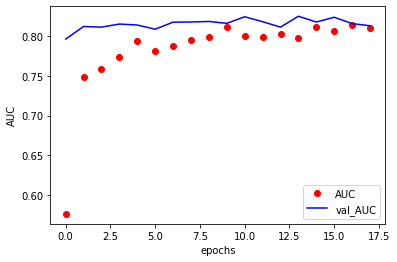

In [ ]:
# epoch별 model acc 비교하기 

import matplotlib.pyplot as plt

history = cnn_history.history
history
loss = history['loss']
acc = history['acc']
auc = history['auc']
val_loss = history['val_loss']
val_acc = history['val_acc']
val_auc = history['val_auc']
length = len(val_loss)

plt.plot(range(length), auc, 'ro', label='AUC')
plt.plot(range(length), val_auc, 'b-', label='val_AUC')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend()

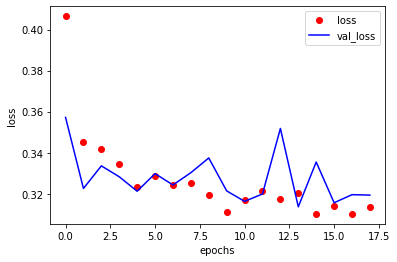

In [ ]:
# epoch별 모델 loss 확인하기

plt.plot(range(length), loss, 'ro', label='loss')
plt.plot(range(length), val_loss, 'b-', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
# test acc 구하기

test_loss, test_acc, test_auc = regression_GRU.evaluate(X_test_3d, y_test_3d)
print(f'test_acc: {test_acc:.4f}')
print(f'test_auc: {test_auc:.4f}')

13/13 [==============================] - 1s 40ms/step - loss: 0.3016 - acc: 0.8825 - auc: 0.8291
test_acc: 0.8825
test_auc: 0.8291


In [ ]:
from keras.models import load_model
from sklearn.metrics import roc_auc_score
loaded_model = load_model(path+'cnn_model.h5')

test_loss, test_acc, test_auc = loaded_model.evaluate(X_test_3d, y_test_3d)
test_pred = loaded_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 1s 39ms/step
acc_test: 0.8700
auc_score_test: 0.7755


In [ ]:

# auroc 구하기

from sklearn.metrics import roc_auc_score

test_pred = regression_GRU.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 1s 39ms/step
acc_test: 0.8700
auc_score_test: 0.8303
